# Pseudotime for GAMM pig retinal organoid sample

## First we use palantir to construct a pseudo time

In [44]:
# Palantir
# source .venv/bin/activate
# load packages

import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

# variables
DATA_DIR = "/Users/bmoore/Desktop/scRNAseq/GAMM/human_ref/output_seurat_mapping_20230913_100651_cc/"
ADATA_FILE = "gamms2_cca_pred.h5ad"
ANNOT_TYPE = "seurat_map" # "seurat_map", "clustifyr", "manual"
NC = 8 # number of components

In [45]:
# load data
## note- data was previously converted from seurat object to anndata object

# data_dir = os.path.expanduser("/Users/bmoore/Desktop/scRNAseq/GAMM/GAMM_S2/output_20230830_155530/")
# adata = sc.read_h5ad(data_dir + "gamms2_clustifyr.h5ad")
data_dir = os.path.expanduser(DATA_DIR)
adata = sc.read_h5ad(data_dir + ADATA_FILE)
adata

AnnData object with n_obs × n_vars = 9716 × 14469
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sizeFactors', 'predicted.id', 'prediction.score.Prog', 'prediction.score.iMG', 'prediction.score.AC', 'prediction.score.Prog.Glia', 'prediction.score.PR', 'prediction.score.HC', 'prediction.score.RGC', 'prediction.score.BC', 'prediction.score.T1.T3', 'prediction.score.max', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'prediction.match', 'predicted.celltype.score', 'predicted.celltype'
    var: 'features'
    obsm: 'X_cca', 'X_pca', 'X_ref.umap', 'X_umap'
    varm: 'PCs'

In [46]:
# WE have already preprocessed this data

# Now create a diffusion map

# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=NC)
# low dim embedding of the data is estimated based on the eigen gap
ms_data = palantir.utils.determine_multiscale_space(adata)

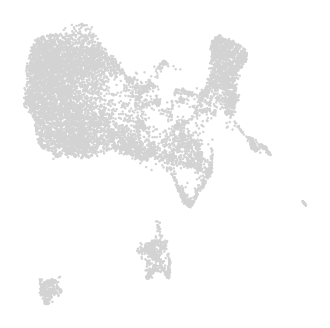

In [47]:
# visualize (note we have already done nearest neighbor and umap)
sc.pl.embedding(
    adata,
    basis="umap",
    frameon=False,
)

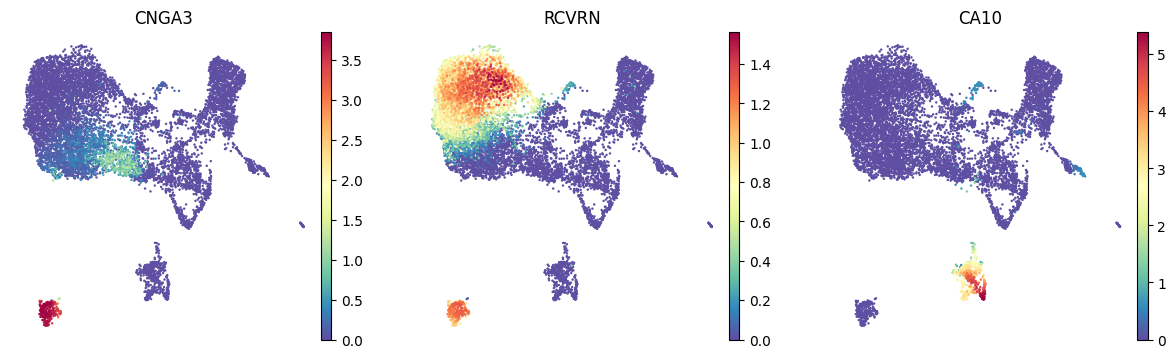

In [48]:
# MAGIC imputation
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imputed_X = palantir.utils.run_magic_imputation(adata)
# gene expression visualization on UMAP
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CNGA3", "RCVRN", "CA10"], # "TUBB3", "SOX2" not in cross species
    frameon=False,
)
plt.show()

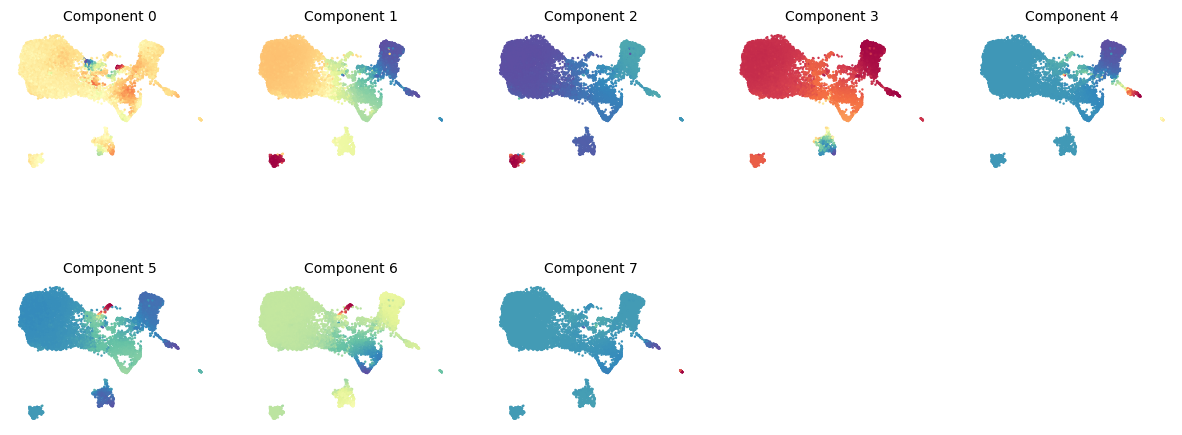

In [50]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(adata)
plt.savefig(data_dir + 'palantir_components_umap.png')
plt.show()

In [56]:
# find terminal states

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    set(adata.obs['clustifyr_call_consol_type'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs","Cones","Bipolar Cells", "Muller Glia"],celltype_column="clustifyr_call_consol_type")
elif ANNOT_TYPE == "manual":
    # manual annotation
    set(adata.obs['CellType'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs-Rods","Cones-Pan PRs","Bipolar Cells", "Muller Glia","Ganglion cell","Bipolar Cells-Ganglion cell"],celltype_column="CellType")
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping annotation
    set(adata.obs['predicted.celltype'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["AC","BC","HC", "PR","RGC","iMG"],celltype_column="predicted.celltype")
else:
    print("Error: invalid annotation type")

Using TTTACTGGTTTACGTG_2 for cell type AC which is min in diffusion component 5.
Using TCGAAGTCAATACCCA_2 for cell type BC which is min in diffusion component 2.
Using CTTCCGAGTACATACC_2 for cell type PR which is max in diffusion component 0.
Using ACCGTTCAGAGCTGCA_2 for cell type iMG which is min in diffusion component 0.


/Users/bmoore/Desktop/GitHub/scRNAseq_library/sc_pipeline/src/venv/lib/python3.11/site-packages/palantir/utils.py:927: UserWarning: No valid component found: HC Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type HC will be skipped.
  warn(
/Users/bmoore/Desktop/GitHub/scRNAseq_library/sc_pipeline/src/venv/lib/python3.11/site-packages/palantir/utils.py:927: UserWarning: No valid component found: RGC Consider increasing the number of diffusion components ('n_components' in palantir.utils.run_diffusion_maps). The cell type RGC will be skipped.
  warn(


In [57]:
set(adata.obs['predicted.celltype'])
print(terminal_states)

TTTACTGGTTTACGTG_2     AC
TCGAAGTCAATACCCA_2     BC
CTTCCGAGTACATACC_2     PR
ACCGTTCAGAGCTGCA_2    iMG
dtype: object


In [60]:
# find start cell

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    # use Retinal Prog to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Prog",celltype_column="clustifyr_call_consol_type",fallback_seed=1234)
elif ANNOT_TYPE == "manual":
    # manual annotation
    # use Retinal Progenitor-Muller Glia to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Progenitor-Muller Glia",celltype_column="CellType",fallback_seed=1234)
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping
    start_cell = palantir.utils.early_cell(adata,celltype="Prog",celltype_column="predicted.celltype",fallback_seed=1234)
else:
    print("Error: invalid annotation type")

Falling back to slow early cell detection.
Sampling and flocking waypoints...
Time for determining waypoints: 0.005635118484497071 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.13016083240509033 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...
Using AAAGAACGTCGTCAGC_2 for cell type Prog which is latest cell in Prog when starting from GGAATGGGTCGAATTC_2.


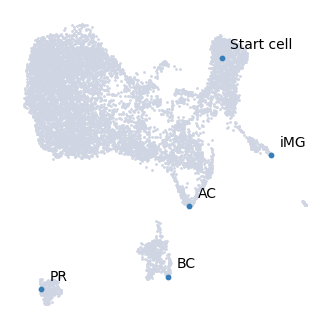

Sampling and flocking waypoints...
Time for determining waypoints: 0.0016835292180379232 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.09428546826044719 minutes
Iteratively refining the pseudotime...


ERROR:tornado.general:SEND Error: Host unreachable


Correlation at iteration 1: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Sampling and flocking waypoints...
Time for determining waypoints: 0.001421968142191569 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


Sampling and flocking waypoints...
Time for determining waypoints: 0.0013935009638468424 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...


21791.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.15s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
21791.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that 

In [ ]:
# use cells found for start cell and terminal states for palantir analysis

# plot with terminal cells and start cell
all_cells = terminal_states
all_cells[start_cell] = "Start cell"
palantir.plot.highlight_cells_on_umap(adata, all_cells)
plt.savefig(data_dir + 'palantir_terminal_cells.png')
plt.show()

# Run Palantir
pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
)
# to run without known terminal states
# pr_res2 = palantir.core.run_palantir(
#     adata, start_cell, num_waypoints=500
# )

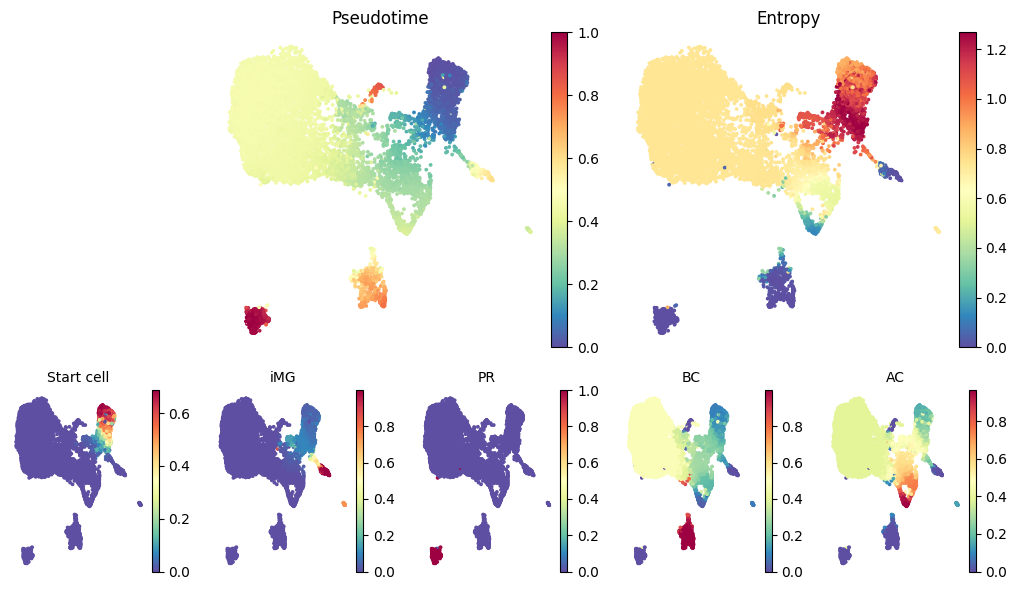

In [ ]:
# plot results
palantir.plot.plot_palantir_results(adata, s=3)
plt.savefig(data_dir + 'palantir_results.png')
plt.show()

Index(['TTTACTGGTTTACGTG_2', 'TCGAAGTCAATACCCA_2', 'CTTCCGAGTACATACC_2',
       'ACCGTTCAGAGCTGCA_2', 'AAAGAACGTCGTCAGC_2'],
      dtype='object')


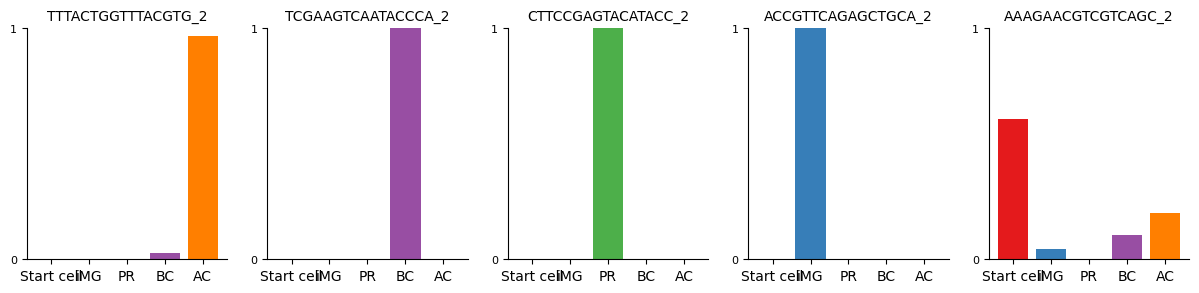

In [68]:
# Terminal state probability distributions of individual cells can be visualized using the plot_terminal_state_probs function

cells=all_cells.index
print(cells)
palantir.plot.plot_terminal_state_probs(adata, cells)
plt.show()

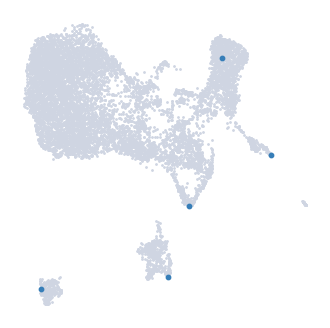

In [30]:
# highlight cells on UMAP
palantir.plot.highlight_cells_on_umap(adata, cells)
plt.show()

/Users/bmoore/Desktop/GitHub/scRNAseq_library/sc_pipeline/src/venv/lib/python3.11/site-packages/palantir/presults.py:566: RuntimeWarning: invalid value encountered in cast
  masks = np.empty_like(fate_probs).astype(bool)


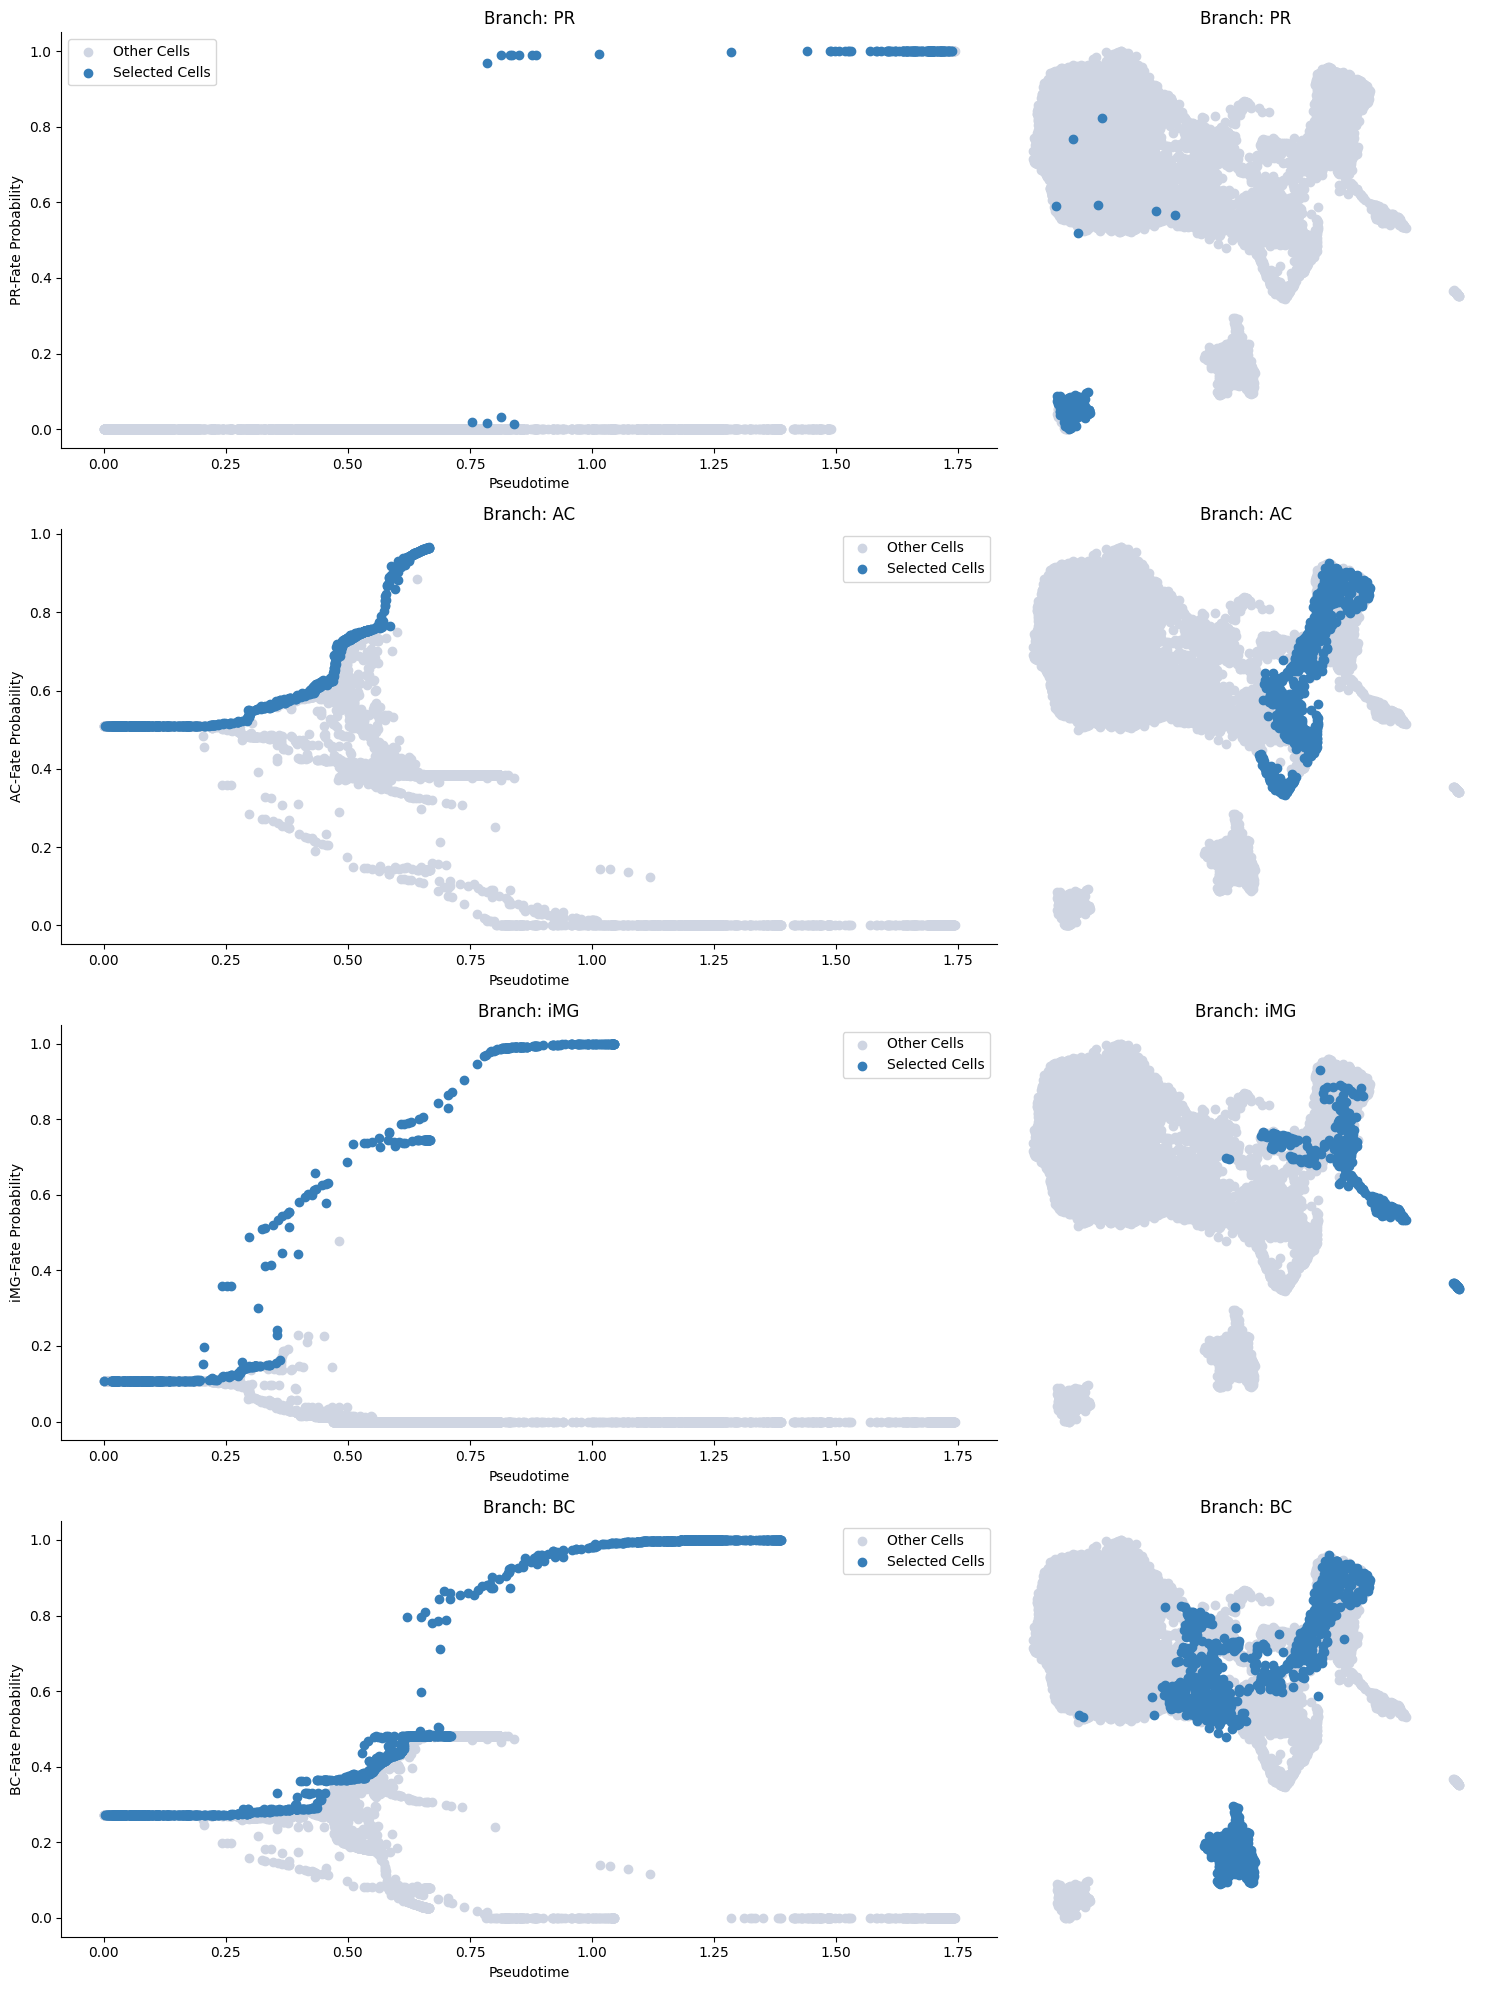

In [31]:
# Gene expression trends

# Select cells
# Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory.
masks = palantir.presults.select_branch_cells(adata, eps=0)
# visualize the branck selection
palantir.plot.plot_branch_selection(adata)
plt.show()

iMG
[2023-10-17 10:53:21,943] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (482) and rank = 1.0.
[2023-10-17 10:53:21,944] [INFO    ] Using covariance function Matern52(ls=1.0).
PR
[2023-10-17 10:53:23,454] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (134) and rank = 1.0.
[2023-10-17 10:53:23,456] [INFO    ] Using covariance function Matern52(ls=1.0).
BC
[2023-10-17 10:53:24,376] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,390) and rank = 1.0.
[2023-10-17 10:53:24,376] [INFO    ] Using covariance function Matern52(ls=1.0).
AC
[2023-10-17 10:53:25,302] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (876) and rank = 1.0.
[2023-10-17 10:53:25,303] [INFO    ] Using covariance function Matern52(ls=1.0).


KeyError: 'TUBB3'

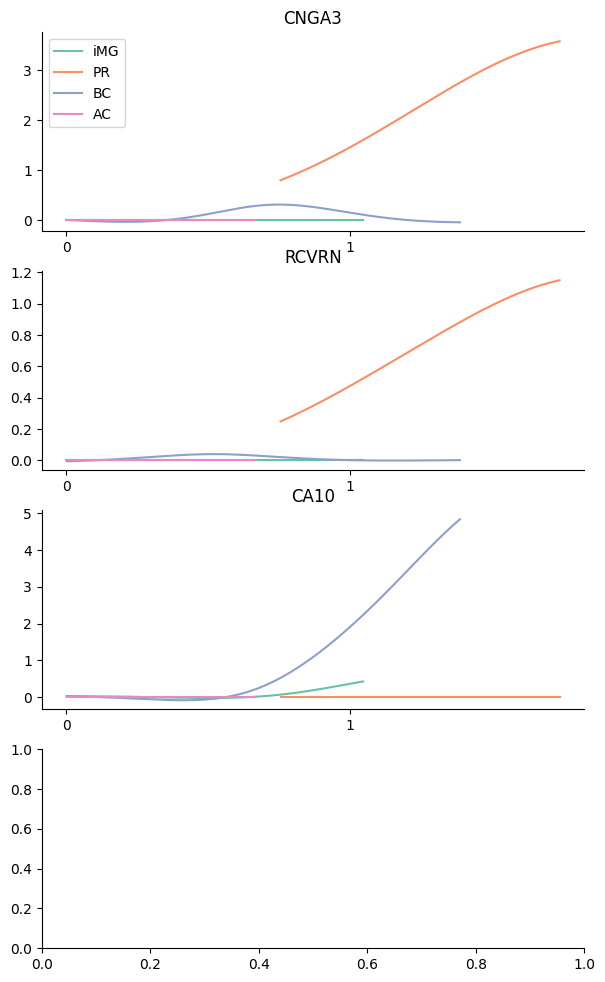

In [32]:
# Determine marker gene trends using the  Mellon Function Estimator
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)
# visualize trends
genes = ["CNGA3", "RCVRN", "CA10", "TUBB3","SOX2"]
palantir.plot.plot_gene_trends(adata, genes)
plt.show()

KeyError: "['TUBB3', 'SOX2'] not in index"

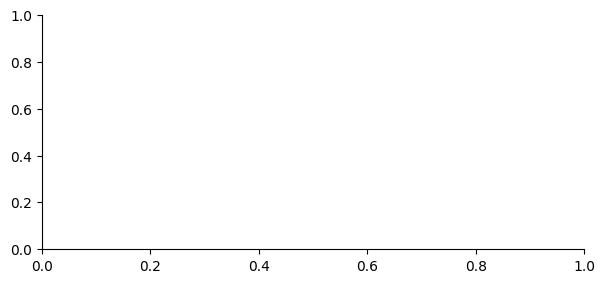

In [33]:
# Heatmap trend visualization
palantir.plot.plot_gene_trend_heatmaps(adata, genes)
plt.show()

/Users/bmoore/Desktop/GitHub/scRNAseq_library/sc_pipeline/src/venv/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


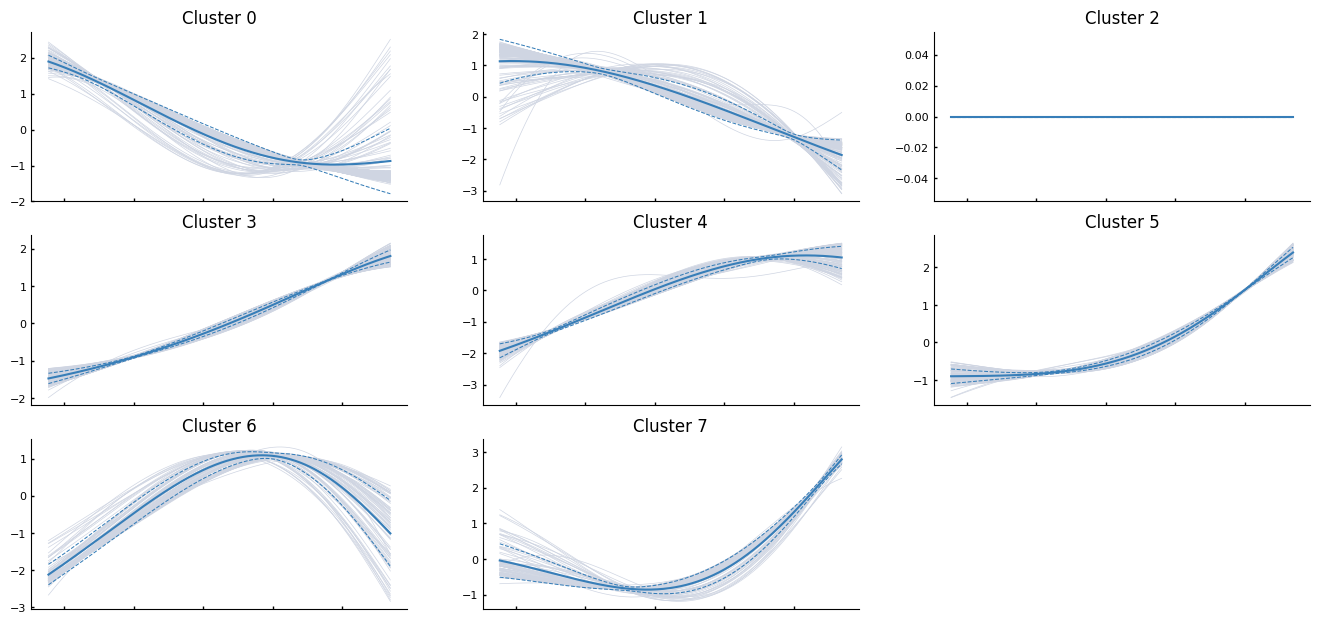

In [34]:
# Clustering
# Gene expression trends can be clustered and visualized
# Here the first 1000 genes along the cones genes are clustered
more_genes = adata.var_names[:1000]
# clustifyr
# communities = palantir.presults.cluster_gene_trends(adata, "Cones", more_genes)
# palantir.plot.plot_gene_trend_clusters(adata, "Cones")
# manual annotation
# communities = palantir.presults.cluster_gene_trends(adata, "Cones-Pan PRs", more_genes)
# palantir.plot.plot_gene_trend_clusters(adata, "Cones-Pan PRs")
# seurat mapping
communities = palantir.presults.cluster_gene_trends(adata, "PR", more_genes)
palantir.plot.plot_gene_trend_clusters(adata, "PR")
plt.show()

In [35]:
adata
# weird seurat to anndata thing- anndata doesn not like a column named _index
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [36]:
import numpy as np
import cellrank as cr
import scanpy as sc
import scvelo as scv
# compute diffusion pseudotime (DPT)
# start by computing a diffusion map
# need to recompute nearest neighbots first
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.diffmap(adata)

In [37]:
# find root cell
adata.obsm['X_diffmap'][:, 3].argmax()

3507

/Users/bmoore/Desktop/GitHub/scRNAseq_library/sc_pipeline/src/venv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


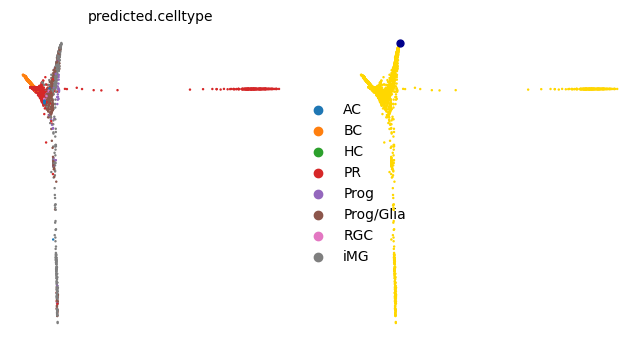

In [38]:
# visualize and set root
root_ixs = 3507  # 9853 for manual/clustifyr
scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['predicted.celltype', root_ixs], # clustifyr_call_consol_type, CellType
    legend_loc="right",
    components=["2, 4"],
)

adata.uns["iroot"] = root_ixs

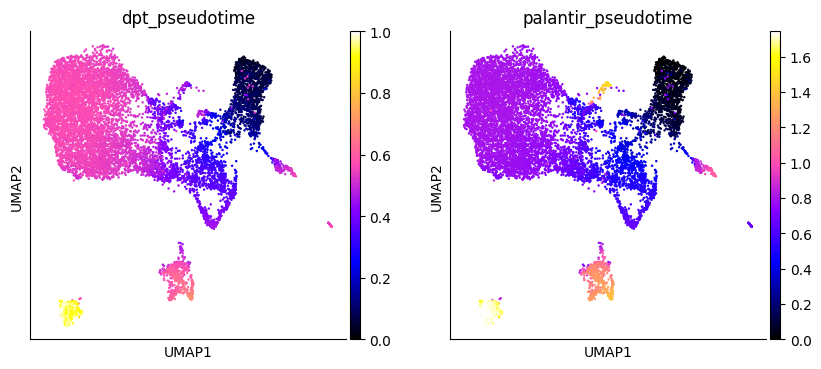

In [39]:
# Once we found a root cell we’re happy with (a cell from the HSC cluster), we can compute DPT and compare it with the precomputed Palantir pseudotime:
sc.tl.dpt(adata)
sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
)

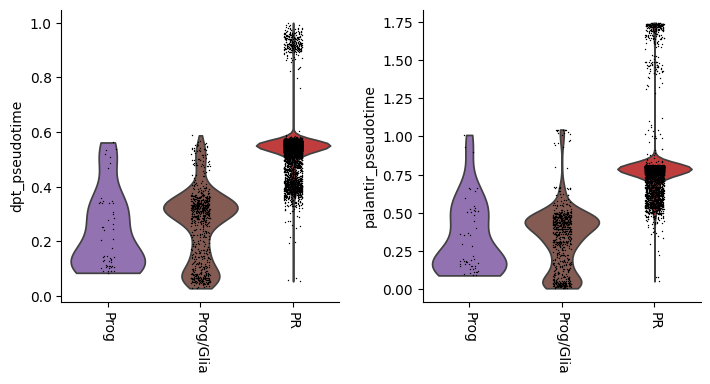

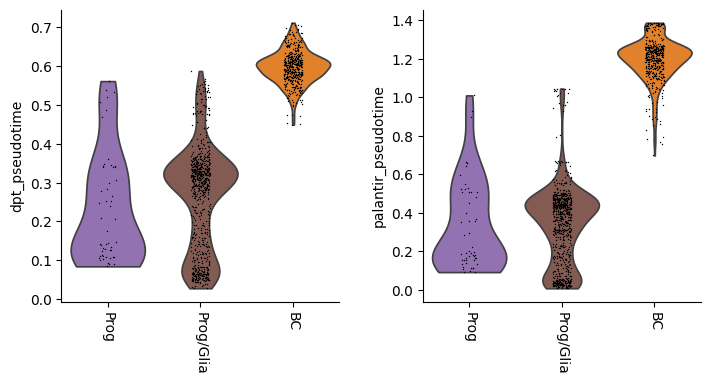

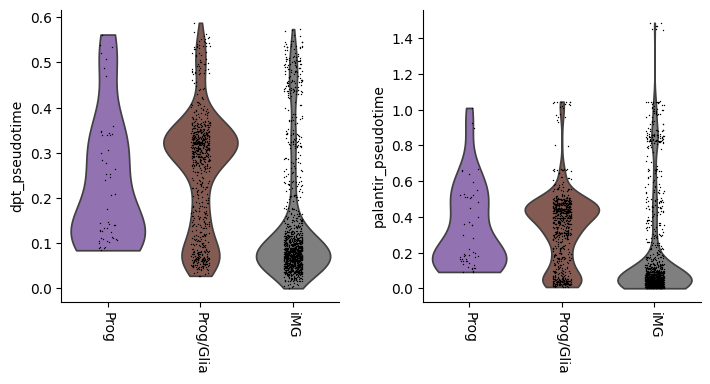

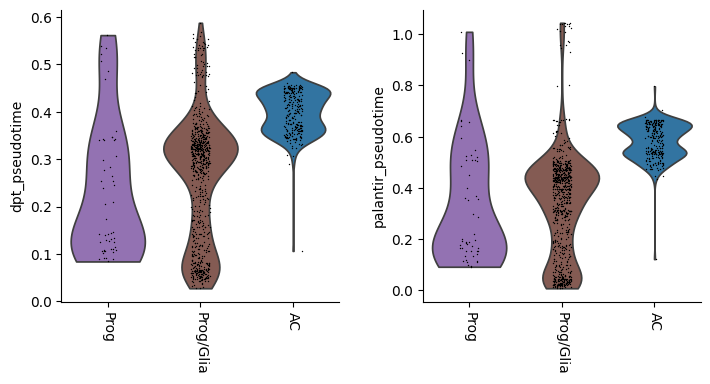

In [40]:
# plot trajectory
# cone_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Pan PRs","Cones-Pan PRs"] #["Retinal Prog", "Pan PRs", "Cones"]
# bipolar_trajectory = ["Retinal Progenitor-Muller Glia","unknown","Bipolar Cells","Bipolar Cells-Ganglion cell"] #["Retinal Prog", "Muller Glia", "Bipolar Cells"]
# rod_trajectory = ["Retinal Progenitor-Muller Glia","Muller Glia-PanPRs-Rods","Pan PRs","Pan PRs-Rods"] #["Retinal Prog", "Pan PRs", "Pan PRs-Rods"]
# seurat mapping
pr_trajectory = ["Prog","Prog/Glia","PR"]
bipolar_trajectory = ["Prog","Prog/Glia","BC"]
img_trajectory = ["Prog","Prog/Glia","iMG"]
ac_trajectory = ["Prog","Prog/Glia","AC"]

# # plot the cone trajectory
# mask = np.in1d(adata.obs["CellType"], cone_trajectory) # clustifyr_call_consol_type
# sc.pl.violin(
#     adata[mask],
#     keys=["dpt_pseudotime", "palantir_pseudotime"],
#     groupby="CellType",                                # clustifyr_call_consol_type
#     rotation=-90,
#     order=cone_trajectory,
# )

# # plot the bipolar trajectory
# mask = np.in1d(adata.obs["CellType"], bipolar_trajectory) # clustifyr_call_consol_type
# sc.pl.violin(
#     adata[mask],
#     keys=["dpt_pseudotime", "palantir_pseudotime"],
#     groupby="CellType",                           # clustifyr_call_consol_type
#     rotation=-90,
#     order=bipolar_trajectory,
# )

# # plot the rod trajectory
# mask = np.in1d(adata.obs["CellType"], rod_trajectory) 
# sc.pl.violin(
#     adata[mask],
#     keys=["dpt_pseudotime", "palantir_pseudotime"],
#     groupby="CellType",                          
#     rotation=-90,
#     order=rod_trajectory,
# )

# plot the PR trajectory
mask = np.in1d(adata.obs["predicted.celltype"], pr_trajectory)
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="predicted.celltype",                          
    rotation=-90,
    order=pr_trajectory,
)

# plot the bipolar trajectory
mask = np.in1d(adata.obs["predicted.celltype"], bipolar_trajectory)
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="predicted.celltype",                          
    rotation=-90,
    order=bipolar_trajectory,
)

# plot the iMG trajectory
mask = np.in1d(adata.obs["predicted.celltype"], img_trajectory)
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="predicted.celltype",                          
    rotation=-90,
    order=img_trajectory,
)

# plot the AC trajectory
mask = np.in1d(adata.obs["predicted.celltype"], ac_trajectory)
sc.pl.violin(
    adata[mask],
    keys=["dpt_pseudotime", "palantir_pseudotime"],
    groupby="predicted.celltype",                          
    rotation=-90,
    order=ac_trajectory,
)

In [41]:
# Compute a transition matrix based on Palantir pseudotime
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

print(pk)

100%|██████████| 9716/9716 [00:00<00:00, 11036.70cell/s]


PseudotimeKernel[n=9716]


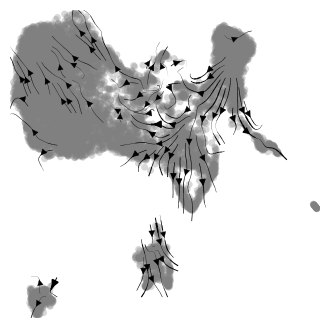

In [42]:
# visualize based on pseudotime and transition matrix
pk.plot_projection(basis="umap", recompute=True)

In [43]:
# Save results
file_path = os.path.join(data_dir, "GAMMS2_pseudotime_processed.h5ad")
adata.write(file_path)
# package versions
import pkg_resources

for package in pkg_resources.working_set:
    print(package.key, pkg_resources.get_distribution(package).version)

fsspec 2023.9.2
xarray 2023.9.0
certifi 2023.7.22
pytz 2023.3.post1
tzdata 2023.3
setuptools 65.5.0
pyzmq 25.1.1
pip 23.2.1
packaging 23.2
attrs 23.1.0
contextlib2 21.6.0
rich 13.6.0
websockets 11.0.3
pillow 10.0.1
ipython 8.16.1
natsort 8.4.0
jupyter-client 8.4.0
click 8.1.7
ipykernel 6.25.2
deepdiff 6.6.0
tornado 6.3.3
importlib-resources 6.1.0
multidict 6.0.4
pyyaml 6.0.1
traitlets 5.11.2
psutil 5.9.5
jupyter-core 5.4.0
decorator 5.1.1
tzlocal 5.1
tqdm 4.66.1
fonttools 4.43.1
protobuf 4.24.4
beautifulsoup4 4.12.2
typing-extensions 4.8.0
pexpect 4.8.0
gdown 4.7.1
progressbar2 4.2.0
ordered-set 4.1.0
readchar 4.0.5
async-timeout 4.0.3
cmake 3.27.6
zipp 3.17.0
filelock 3.12.4
platformdirs 3.11.0
h5py 3.10.0
aiohttp 3.8.6
python-utils 3.8.1
matplotlib 3.8.0
anyio 3.7.1
rpy2 3.5.14
idna 3.4
charset-normalizer 3.3.0
opt-einsum 3.3.0
threadpoolctl 3.2.0
inquirer 3.1.3
jinja2 3.1.2
pyparsing 3.1.1
networkx 3.1
prompt-toolkit 3.0.39
loompy 3.0.7
cython 3.0.3
markdown-it-py 3.0.0
requests 2.3